In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import matplotlib.pyplot as plt

np.random.seed(0)
tf.set_random_seed(0)

class VAE:
    def __init__(self, n_input, n_z, n_hidden_units, batch_size, learning_rate):

        self.n_input = n_input
        self.n_z = n_z
        self.n_hidden_units = n_hidden_units

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        # define placeholder
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, self.n_input], name='x')

        self._build_network()

        # define loss
        # self.recon_loss = tf.reduce_sum(tf.square(self.x - self.x_mean) / (2 * tf.exp(self.x_sigma)), 1)
        # self.recon_loss = tf.reduce_sum(tf.squared_difference(self.x, self.x_mean), 1)
        self.recon_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_mean)
                                         + (1 - self.x) * tf.log(1e-10 + 1 - self.x_mean), 1)
        
        self.latent_loss = -0.5 * tf.reduce_sum(1.0 + self.z_sigma - tf.square(self.z_mean) - tf.exp(self.z_sigma), 1)
        self.loss = tf.reduce_mean(self.recon_loss + self.latent_loss)
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        # summary
        tf.summary.scalar('recon_loss', tf.reduce_mean(self.recon_loss))
        tf.summary.scalar('latent_loss', tf.reduce_mean(self.latent_loss))
        tf.summary.scalar('total_loss', self.loss)
        self.loss_logger = tf.summary.merge_all()

    def _build_network(self):
        self.z_mean, self.z_sigma = self._build_encoder()
        epsilon = tf.random_normal((self.batch_size, self.n_z), mean=0.0, stddev=1.0)
        self.z = tf.multiply(tf.sqrt(tf.exp(self.z_sigma)), epsilon) + self.z_mean
        self.x_mean = self._build_decoder()

    def _build_encoder(self):
        weights_init = tf.random_normal_initializer(stddev=0.01)
        bias_init = tf.random_normal_initializer(stddev=0.01)
        with tf.variable_scope('encoder'):
            encoder_h = tf.layers.dense(self.x, self.n_hidden_units, tf.nn.tanh,
                                        kernel_initializer=weights_init, bias_initializer=bias_init,
                                        name='encoder_h')
            z_mean = tf.layers.dense(encoder_h, self.n_z,
                                     kernel_initializer=weights_init, bias_initializer=bias_init,
                                     name='z_mean')
            z_sigma = tf.layers.dense(encoder_h, self.n_z,
                                      kernel_initializer=weights_init, bias_initializer=bias_init,
                                      name='z_log_sigma_square')
            return z_mean, z_sigma

    def _build_decoder(self):
        weights_init = tf.random_normal_initializer(stddev=0.01)
        bias_init = tf.random_normal_initializer(stddev=0.01)
        with tf.variable_scope('decoder'):
            decoder_h = tf.layers.dense(self.z, self.n_hidden_units, tf.nn.tanh,
                                        kernel_initializer=weights_init, bias_initializer=bias_init,
                                        name='decoder_h')
            x_mean = tf.layers.dense(decoder_h, self.n_input, tf.nn.sigmoid,
                                     kernel_initializer=weights_init, bias_initializer=bias_init,
                                     name='x_mean')
            return x_mean

In [2]:
n_z = 10
batch_size = 100

model = VAE(n_input=784, n_z=n_z, n_hidden_units=500, batch_size=batch_size, learning_rate=0.001)
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [3]:
# load model and generate samples
checkpoint_path = 'save/square/'
checkpoint = tf.train.latest_checkpoint(checkpoint_path)
saver.restore(sess, checkpoint)
print('Restoring the model from %s' % checkpoint)


INFO:tensorflow:Restoring parameters from save/square/vae_mnist_model-200
Restoring the model from save/square/vae_mnist_model-200


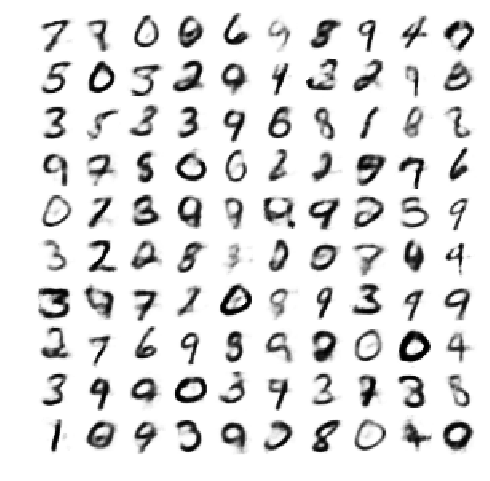

In [12]:
nx, ny = 10, 10
n_generate = nx * ny
random_z = [np.random.normal(0, 1, n_z) for _ in range(n_generate)]
imgs = sess.run(model.x_mean, feed_dict={model.z: random_z})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

canvas = np.empty((28*ny, 28*nx))
for i in range(nx):
    for j in range(ny):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = imgs[i*nx+j].reshape(28, 28)

plt.figure(figsize=(8, 10))        
plt.imshow(1-canvas, cmap="gray")
plt.axis('off')
plt.savefig('generated_samples.eps')
plt.show()